In [2]:
from keras.preprocessing import image as image_utils
import numpy as np
import pandas as pd

In [3]:
from skimage.io import imread
from skimage.color import gray2rgb
from skimage.transform import resize
import os, os.path
file_names = []
data = [] 

for f in os.listdir():
    ext = os.path.splitext(f)[1]
    if ext == ".JPEG":
        file_names.append(os.path.splitext(f)[0][:9])
        x = imread(f)
        if len(x.shape) == 2:
            x = gray2rgb(x)
            
        x = resize(x, (64,64,3))
        data.append(x)      
        
print ("Image import complete")     

data = np.array(data)


Image import complete


In [4]:
classes = pd.factorize(file_names)
Y = classes[0]

## Autoencoder

In [7]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard

In [8]:
input_img = Input(shape=(64, 64, 3))

x = Conv2D(32, (3,3), activation='relu', padding='same', dilation_rate=(1,1))(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(3, (2,2), activation='sigmoid', padding='same')(x)


In [9]:
autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['mse'])

encoder = Model(input_img, encoded)

In [10]:
autoencoder.fit(data, data,
               epochs=   10,
               batch_size=128,
               shuffle=True)

Epoch 1/10
8987/8987 [==============================] - 138s - loss: 0.6735 - mean_squared_error: 0.0692   
Epoch 2/10
8987/8987 [==============================] - 138s - loss: 0.6061 - mean_squared_error: 0.0383   
Epoch 3/10
8987/8987 [==============================] - 138s - loss: 0.5838 - mean_squared_error: 0.0289   
Epoch 4/10
8987/8987 [==============================] - 138s - loss: 0.5740 - mean_squared_error: 0.0249   
Epoch 5/10
8987/8987 [==============================] - 138s - loss: 0.5691 - mean_squared_error: 0.0230   
Epoch 6/10
8987/8987 [==============================] - 137s - loss: 0.5649 - mean_squared_error: 0.0213   
Epoch 7/10
8987/8987 [==============================] - 138s - loss: 0.5627 - mean_squared_error: 0.0205   
Epoch 8/10
8987/8987 [==============================] - 137s - loss: 0.5612 - mean_squared_error: 0.0199   
Epoch 9/10
8987/8987 [==============================] - 138s - loss: 0.5589 - mean_squared_error: 0.0190   
Epoch 10/10
8987/8987 [=====

In [11]:
X_enc = encoder.predict(data)
X_enc = X_enc.reshape(len(X_enc),np.prod(X_enc.shape[1:]))

In [12]:
from sklearn.model_selection import train_test_split
X_enc_tr, X_enc_ts, Y_enc_tr, Y_enc_ts = train_test_split(X_enc, Y, test_size = 0.2, random_state = 20)

## Vectorization using SVD

In [13]:
X_svd = data.reshape(len(data),np.prod(data.shape[1:])) # flattening data to plug into SVD

In [14]:
sig = np.linalg.svd(X_svd, full_matrices = False, compute_uv = False)


We will use a scree plot to determine the number of singular values to retain.


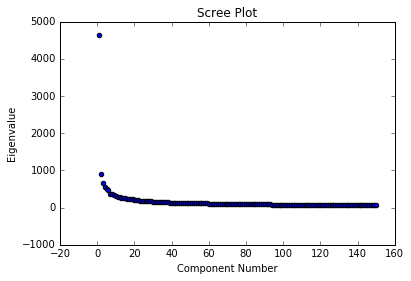

In [16]:
import matplotlib.pyplot as plt 
%matplotlib inline
x1, y1 = zip(*(enumerate(sig[:150])))
x1 = [x+1 for x in x1]
plt.scatter(x1,y1)
plt.xlabel("Component Number")
plt.ylabel("Eigenvalue")
plt.title("Scree Plot")
plt.show()

We can take the number of components ($k$) to be $120$ based on the plot above.

In [17]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=120, n_iter=20, random_state=20)
X_svd = svd.fit_transform(X_svd)

In [18]:

X_svd_tr, X_svd_ts, Y_svd_tr, Y_svd_ts = train_test_split(X_svd, Y, test_size = 0.2, random_state = 20)

## Histograms

In [24]:
#rgb histogram
X_rgb_hist =np.zeros(shape=(data.shape[0],256*3))
for i in range(data.shape[0]):
    hist_r=np.histogram(data[i,:,:,0], bins = 256)[0]
    hist_g=np.histogram(data[i,:,:,1], bins = 256)[0]
    hist_b=np.histogram(data[i,:,:,2], bins = 256)[0]
    hist = np.concatenate((hist_r,hist_g,hist_b))
    X_rgb_hist[i,:] = hist 

In [25]:
X_rgb_tr, X_rgb_ts, Y_rgb_tr, Y_rgb_ts = train_test_split(X_rgb_hist, Y, test_size = 0.2, random_state = 20) #X_rgb_hist

In [27]:
#hsv histogram
from skimage.color import rgb2hsv  
X_hsv_hist = np.zeros(shape=(data.shape[0],256*3))
for i in range(data.shape[0]):
    hsv_image = rgb2hsv(data[i, :, :, :])
    hist_r=np.histogram(data[i,:,:,0], bins = 256)[0]
    hist_g=np.histogram(data[i,:,:,1], bins = 256)[0]
    hist_b=np.histogram(data[i,:,:,2], bins = 256)[0]
    hist = np.concatenate((hist_r,hist_g,hist_b))
    X_hsv_hist[i,:] = hist 


In [28]:
X_hsv_tr, X_hsv_ts, Y_hsv_tr, Y_hsv_ts = train_test_split(X_hsv_hist, Y, test_size = 0.2, random_state = 20)

## KNN

In [36]:
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import correlation

def calc_dist(X_train, X_test, Y_train, metric, row, k = 5):
    dist = []
    if metric == "euclidean":
        for ii in range(X_train.shape[0]):
            dist.append((ii, np.sqrt(np.sum((X_train[ii,:] - X_test[row,:])**2))))
        dist.sort(key = lambda x:x[1])
        top_i = [dist[i][0] for i in range(k)]
        return np.argmax(np.bincount(Y_train[top_i]))
        
    
    elif metric == "pearson":
        for i in range(X_train.shape[0]):
            dist.append((i, correlation(X_train[i,:], X_test[row,:] )))
        dist.sort(key = lambda x:x[1])
        top_i = [dist[i][0] for i in range(k)]
        return np.argmax(np.bincount(Y_train[top_i]))

In [37]:
test_length = X_hsv_ts.shape[0]
ypred_enc_e = np.zeros(test_length)
ypred_enc_p = np.zeros(test_length)
ypred_svd_e = np.zeros(test_length)
ypred_svd_p = np.zeros(test_length)
ypred_rgb_e = np.zeros(test_length)
ypred_rgb_p = np.zeros(test_length)
ypred_hsv_e = np.zeros(test_length)
ypred_hsv_p = np.zeros(test_length)

In [38]:
for i in  range(test_length):
    ypred_enc_e[i] = calc_dist(X_enc_tr, X_enc_ts, Y_enc_tr,row =i, metric = "euclidean")
    ypred_svd_e[i] = calc_dist(X_svd_tr, X_svd_ts, Y_svd_tr,row =i, metric = "euclidean")
    ypred_rgb_e[i] = calc_dist(X_rgb_tr, X_rgb_ts, Y_rgb_tr,row =i, metric = "euclidean")
    ypred_hsv_e[i] = calc_dist(X_hsv_tr, X_hsv_ts, Y_hsv_tr, row =i,metric = "euclidean")
    ypred_enc_p[i] = calc_dist(X_enc_tr, X_enc_ts, Y_enc_tr,row =i, metric = "pearson")
    ypred_svd_p[i] = calc_dist(X_svd_tr, X_svd_ts, Y_svd_tr,row =i, metric = "pearson")
    ypred_rgb_p[i] = calc_dist(X_rgb_tr, X_rgb_ts, Y_rgb_tr,row =i, metric = "pearson")
    ypred_hsv_p[i] = calc_dist(X_hsv_tr, X_hsv_ts, Y_hsv_tr, row =i,metric = "pearson")

### Confusion matrices

In [41]:

print('\n--------------------------------------------- \n')
mat_rgb_e = confusion_matrix(Y_rgb_ts,ypred_rgb_e)
acc_rgb_e = 100*np.trace(mat_rgb_e)/np.sum(mat_rgb_e)
print('RGB Euclidean: \n')
print('Accuracy: ',acc_rgb_e, '%' )
print('Confusion Matrix: \n', mat_rgb_e)


print('\n--------------------------------------------- \n')
mat_rgb_p = confusion_matrix(Y_rgb_ts,ypred_rgb_p)
acc_rgb_p = 100*np.trace(mat_rgb_p)/np.sum(mat_rgb_p)
print('RGB Pearson: \n')
print('Accuracy: ',acc_rgb_p, '%' )
print('Confusion Matrix: \n', mat_rgb_p)


print('\n--------------------------------------------- \n')
mat_hsv_e = confusion_matrix(Y_hsv_ts,ypred_hsv_e)
acc_hsv_e = 100*np.trace(mat_hsv_e)/np.sum(mat_hsv_e)
print('HSV Euclidean: \n')
print('Accuracy: ',acc_hsv_e, '%' )
print('Confusion Matrix: \n', mat_hsv_e)


print('\n--------------------------------------------- \n')
mat_hsv_p = confusion_matrix(Y_hsv_ts,ypred_hsv_p)
acc_hsv_p = 100*np.trace(mat_hsv_p)/np.sum(mat_hsv_p)
print('HSV Pearson: \n')
print('Accuracy: ',acc_hsv_p, '%\n')
print('Confusion Matrix: ', mat_hsv_p,'\n')

print('\n--------------------------------------------- \n')
mat_enc_e = confusion_matrix(Y_enc_ts,ypred_enc_e)
acc_enc_e = 100*np.trace(mat_enc_e)/np.sum(mat_enc_e)
print('Autoencoder Euclidean: \n')
print('Accuracy: ',acc_enc_e, '%\n')
print('Confusion Matrix: \n', mat_enc_e,'\n')


print('\n--------------------------------------------- \n')
mat_enc_p = confusion_matrix(Y_enc_ts,ypred_enc_p)
acc_enc_p = 100*np.trace(mat_enc_p)/np.sum(mat_enc_p)
print('Autoencoder Pearson: \n')
print('Accuracy: ',acc_enc_p, '%\n')
print('Confusion Matrix: \n', mat_enc_p,'\n')


print('\n--------------------------------------------- \n')
mat_svd_e = confusion_matrix(Y_svd_ts,ypred_svd_e)
acc_svd_e = 100*np.trace(mat_svd_e)/np.sum(mat_svd_e)
print('SVD Euclidean: \n')
print('Accuracy: ',acc_svd_e, '%\n')
print('Confusion Matrix: \n', mat_svd_e,'\n')


print('\n--------------------------------------------- \n')
mat_svd_p = confusion_matrix(Y_svd_ts,ypred_svd_p)
acc_svd_p = 100*np.trace(mat_svd_p)/np.sum(mat_svd_p)
print('SVD Pearson: \n')
print('Accuracy: ',acc_svd_p, '%\n')
print('Confusion Matrix: \n', mat_svd_p,'\n')



--------------------------------------------- 

RGB Euclidean: 

Accuracy:  36.9299221357 %
Confusion Matrix: 
 [[ 87  37  15  16  20  59]
 [ 42  99  51  16  65  59]
 [ 14  50 111  10  24  51]
 [ 38  67  31  99  50  76]
 [ 21  82  27  25 167  48]
 [ 27  51  34   9  19 101]]

--------------------------------------------- 

RGB Pearson: 

Accuracy:  39.1546162403 %
Confusion Matrix: 
 [[102  29  19  18  33  33]
 [ 51  95  54  28  72  32]
 [ 22  43 117  11  24  43]
 [ 46  88  28 107  57  35]
 [ 32  67  33  17 193  28]
 [ 31  39  52   4  25  90]]

--------------------------------------------- 

HSV Euclidean: 

Accuracy:  36.9299221357 %
Confusion Matrix: 
 [[ 87  37  15  16  20  59]
 [ 42  99  51  16  65  59]
 [ 14  50 111  10  24  51]
 [ 38  67  31  99  50  76]
 [ 21  82  27  25 167  48]
 [ 27  51  34   9  19 101]]

--------------------------------------------- 

HSV Pearson: 

Accuracy:  39.1546162403 %

Confusion Matrix:  [[102  29  19  18  33  33]
 [ 51  95  54  28  72  32]
 [ 22  43